# Topic Modeling Quora Questions with LDA
The algorithm that Quora uses to assign topics to questions is proprietary, so, we would not know exactly how they do it. However, it does not stop us from trying it out in our own ways.
# Problem Description
Quora has all these existing questions, unlabeled, and they need to categorize them and to fit the next step of machine learning pipeline.
# Identify Problems
This is an unsupervised learning problem in which we find various topics that are presented in the Quora questions.
# Objectives
Our goal is to identify the number of topics and determine the theme of each topic. In addition, I tested whether my model can predict the topic theme given any new question.
# Approaches
Apply a LDA and a NMF model to a Quora question data set, and determine the number of topics and theme of each topic.
Sample data set on Github, feel free to use it.


In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, string, gensim

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import seaborn as sns
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """


In [2]:
# downlanding data
import pandas as pd
url = 'https://raw.githubusercontent.com/susanli2016/NLP-with-Python/master/data/quora_sample.csv'
df = pd.read_csv(url,parse_dates=[0])

# You may have noticed that our classes are imbalanced, and we will address this later on.

In [3]:
df.head()

,question_text
0,Why is Saturn V considered an over-estimated r...
1,Why is cheap vodka so good?
2,What does drunk and disorganized mean?
3,How can I prepare for ISRO 2017?
4,What is the probation period after SSC CGL?


In [4]:

print('We have',len(df), 'questions in the data')

We have 9838 questions in the data


These are what questions look like prior to text pre-processing:

In [5]:
a = 5000
for i in range(a,a+10):
    print(df.question_text[i])
    print()

What is your funny view on failures?

What can I do about a racist work environment? (See comments for explaination)

What are the simularitys?

How do I choose my life partner through arrange marriage when I am 33 (already late for marriage) & parents are still rigid with their archaic notions?

What is the ideal Chinese handwriting?

How many sides does a pyramid have?

How do oil painters create or brush straight lines on a painting, given that the canvas surface is wet?

How can I get permission of a biology laboratory (in India) of any research center/institute to perform experiments for startup working on photosynthesis?

Is passive aggression a personality or a one off thing?

How did Rome decline and why is it not taught in history books?



## What we are going to do during the text pre-processing:
* Lowercase
* Removing stopwords, bracket, punctuation and numbers
* Lemmatization using spaCy then removing “-PRON-”.
## What we are not going to do during the text pre-processing:
* Stemming

Stemming removes the last few characters in a word, often leading to incorrect meanings and spelling errors, or making the words un-recognizable, for example: business → busi, busy → busi, situation → situ.
We should try not to do too much of text pre-processing, because most of the questions are short, removing more words risks of losing meaning.

In [6]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

df_clean = pd.DataFrame(df.question_text.apply(lambda x: clean_text(x)))

In [7]:
a = 5000
for i in range(a,a+10):
    print(df_clean.question_text[i])
    print()

what is your funny view on failures

what can i do about a racist work environment see comments for explaination

what are the simularitys

how do i choose my life partner through arrange marriage when i am  already late for marriage  parents are still rigid with their archaic notions

what is the ideal chinese handwriting

how many sides does a pyramid have

how do oil painters create or brush straight lines on a painting given that the canvas surface is wet

how can i get permission of a biology laboratory in india of any research centerinstitute to perform experiments for startup working on photosynthesis

is passive aggression a personality or a one off thing

how did rome decline and why is it not taught in history books



In [8]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [9]:
def lemmatizer(text):
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

In [10]:
df_clean["question_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['question_text']), axis=1)
df_clean['question_lemmatize_clean'] = df_clean['question_lemmatize'].str.replace('-PRON-', '')

In [11]:
df_clean

,question_text,question_lemmatize,question_lemmatize_clean
0,why is saturn v considered an overestimated ro...,why be saturn v consider an overestimated rock...,why be saturn v consider an overestimated rock...
1,why is cheap vodka so good,why be cheap vodka so good,why be cheap vodka so good
2,what does drunk and disorganized mean,what do drunk and disorganized mean,what do drunk and disorganized mean
3,how can i prepare for isro,how can I prepare for isro,how can I prepare for isro
4,what is the probation period after ssc cgl,what be the probation period after ssc cgl,what be the probation period after ssc cgl
...,...,...,...
9833,what would happen if robert mueller is assassi...,what would happen if robert mueller be assassi...,what would happen if robert mueller be assassi...
9834,how did you find out you were autistic,how do you find out you be autistic,how do you find out you be autistic
9835,do you think logan paul should deserve jail ti...,do you think logan paul should deserve jail ti...,do you think logan paul should deserve jail ti...
9836,in nsw australia the state government has priv...,in nsw australia the state government have pri...,in nsw australia the state government have pri...


# EDA

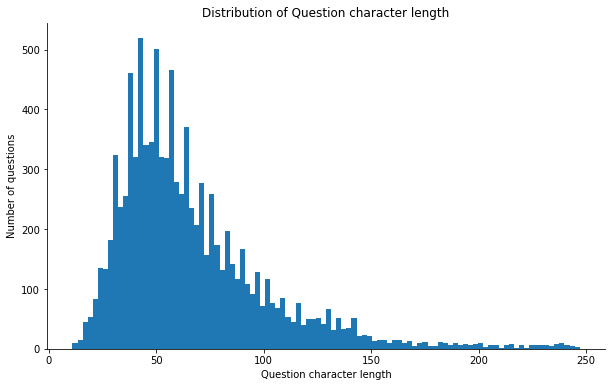

In [12]:
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.question_text]
plt.hist(doc_lens, bins = 100)
plt.title('Distribution of Question character length')
plt.ylabel('Number of questions')
plt.xlabel('Question character length')
sns.despine();

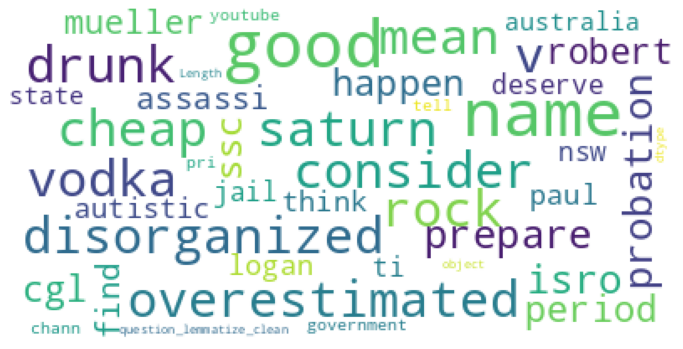

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

mpl.rcParams['figure.figsize']=(12.0,12.0)
mpl.rcParams['font.size']=12
mpl.rcParams['savefig.dpi']=100
mpl.rcParams['figure.subplot.bottom']=.1
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=500,
                          max_font_size=40,
                          random_state=42
                         ).generate(str(df_clean['question_lemmatize_clean']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

# Unigrams

In [14]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df_clean['question_lemmatize_clean'], 30)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 unigrams in the question text after removing stop words and lemmatization"))
fig.show()

# Bigrams

In [15]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df_clean['question_lemmatize_clean'], 20)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 bigrams in the question text after removing stop words and lemmatization"))
fig.show()

# Trigrams

In [16]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df_clean['question_lemmatize_clean'], 20)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

fig = go.Figure([go.Bar(x=df4['trigram'], y=df4['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 trigrams in the question text"))
fig.show()

# Observations:
* A lot of questions were asking “the useful tips to start …” (I assume to start a new career or new job?)
* A lot of questions were about good way to learn something.
* A lot of questions were asking recommendations of hotels for short term business travelers.
* Many people were asking about good or bad neighbors. Assuming they want to move to a new location?
* Some people were considering to write biography.
* There seem to be some duplicate questions, for example: hotels for short term business travelers. Detect duplicate questions will be fun and it’s a subject for another time

# Topic Modeling
* To do topic modeling, the input we need is: document-term matrix. The order of words doesn’t matter. So, we call it “bag-of-words”.
* We can either use scikit-learn or Gensim library, the technique is called “Latent Dirichlet Allocation”, short for “LDA”.
* The output is the number of topics across all the questions in the data and the theme of each topic.

Let’s dive deeper into what exactly document-term matrix is. Let’s say we have three questions in total:
1) How do football players stay safe?
2) What is the most hated NFL football team?
3) Who is the greatest political leader?

The Document-Term Matrix for the three questions is:
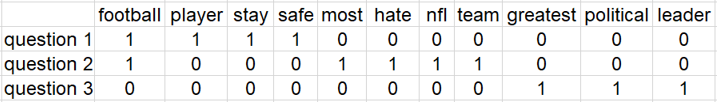


Each row is a question (or document), each column is a term (or word), we label “0” if that document does not contain that term, “1” if that document contains that term once, “2” if that document contains that term twice, and so on.


# Latent Dirichlet Allocation
**Latent** means hidden, **Dirichlet** is a type of probability distribution. **Latent Dirichlet Allocation** means that we are trying to find all the probability distributions and they are hidden.
Let’s continue with our examples. We have four questions here. As humans, we know exactly what each question is about.

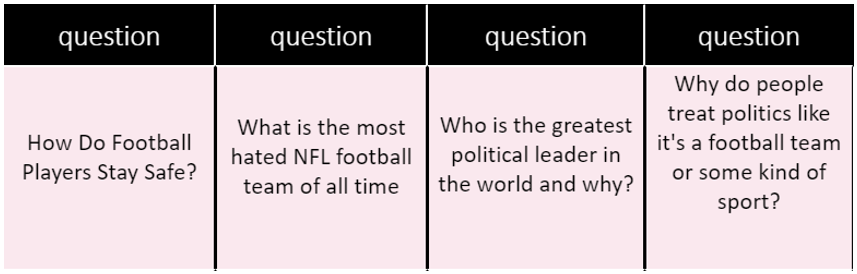

The 1st question is about football, the 3rd question is about politics, and the 4th question is about politics and football. When we fit these 4 questions to LDA, it will give us back something like this:

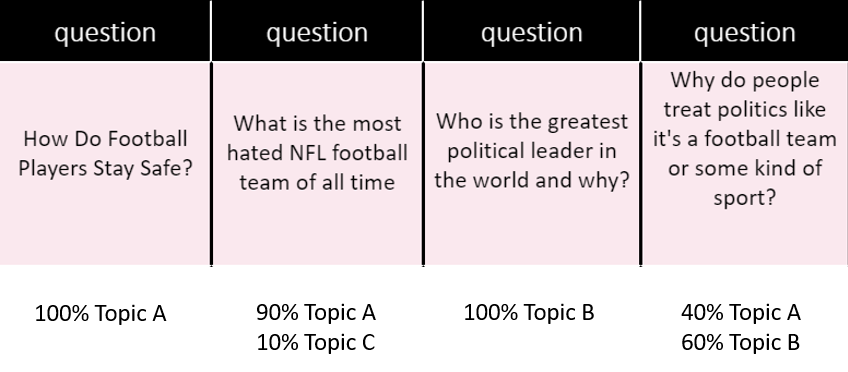

The 1st question is 100% of Topic A, the 3rd question is 100% of Topic B, and the last question is split of Topic A and Topic B. It is our job as humans to interpret them.

The word “football” has the highest weight in Topic A, followed by “NFL” followed by “player”. So we could infer that this topic is about sport.

The word “politics” has the highest weight in Topic B, followed by “leader”, followed by “world”. So we could infer that this topic is about politics. As shown below:

* **Topic A:** 40% football, 30% NFL, 10% player … Sport
* **Topic B:** 30% political, 20% leader, 10% world … Politics
Then we go back to our original questions, here are the topics!

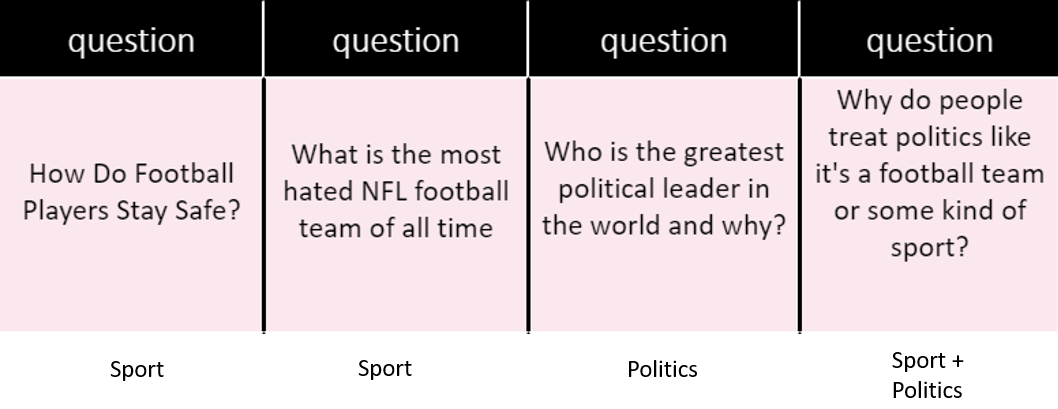

To dive a little deeper, every questions is a mix of topics, and every topic is a mix of words.


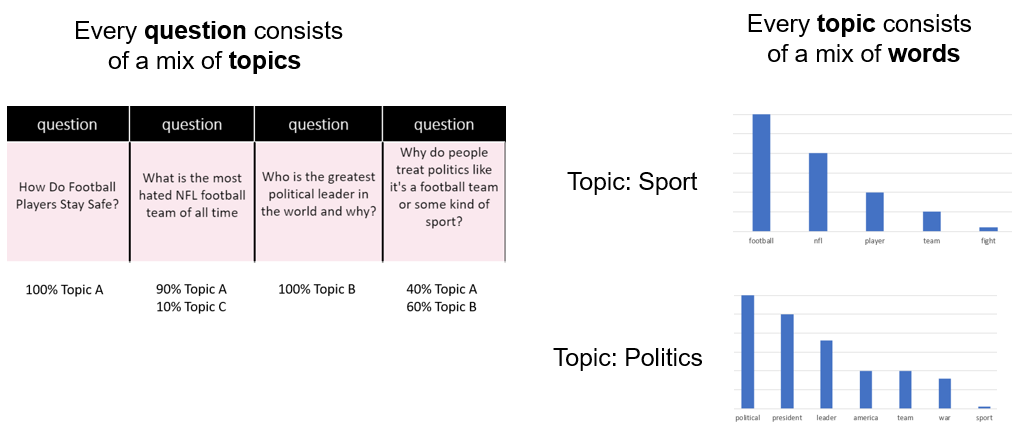

## Technically speaking:
* A question is a probability distribution of topics, and every topic is a probability distribution of words.
* What LDA does is that when you fit it with all those questions, it is trying its best to find the best topic mix and the best word mix.


## Steps on how LDA works:

1. We want LDA to learn the topic mix in each question and the word mix in each topic.
2. Choose the number of topics we think there are in the entire question data set (example: num_topics = 2).
3. Randomly assign each word in each question to one of two topics (example: the word “football” in above question is randomly assigned to Topic B which is politics-like topic)
4. Go through every word and its topic assignment in each question. Look at 1) how often the topic occurs in the question and 2) how often the word occurs in the topic overall. Based on this information, assign the word a new topic (example: it looks like “football” does not occur often in Topic B, so the word “football” probably should be assigned to Topic A).
5. Go through multiple iteration of this. Eventually the topics will start making sense in a way that we could interpret them and give them themes.


Luckily, we only need to give input to LDA, and LDA does all of above dirty work for us.

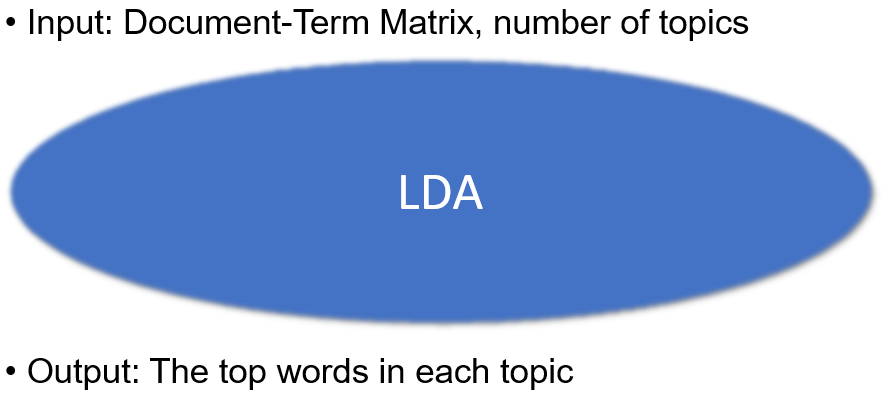


# LDA on 9838 Quora questions
* We are handed with 983,801 Quora questions.
* We want to discover the hidden or latent topics among the whole collection of questions (e.g. technology, politics, science, sports), and try to categorize them by subject matter.
* Choose the number of topics (more topics — finer grain)

**For example**, sports, when we have a lot of topics, we may have football (topic1), tennis(topic2), hockey(topic3) and so on. If we reduce the number of topics, at some point, these sport related topics will collapse themselves and become one topic. Like any unsupervised learning there is no metrics this is better than that one. We basically have to choose for our own use case.

* Run LDA with various approximation schemes, run many times with different schemes to see which is best fit for the particular use case.

# LDA with Gensim
I tried Gensim first, with 20 topics, and …


In [17]:
vectorizer = CountVectorizer(analyzer='word',
                             min_df=3,
                             stop_words='english',
                             lowercase=True,
                             token_pattern='[a-zA-Z0-9]{3,}',
                             max_features=5000,
                            )

data_vectorized = vectorizer.fit_transform(df_clean['question_lemmatize_clean'])

lda_model = LatentDirichletAllocation(n_components=20, # Number of topics
                                      learning_method='online',
                                      random_state=0,
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning:

'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming o

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
8      -10.878068   10.538728       1        1  7.599971
5      -60.884026  -75.591820       2        1  7.132493
12      -2.336119  -53.289074       3        1  6.781432
2      -61.385319  -12.914634       4        1  5.872561
3      -28.737743  126.296997       5        1  5.450016
4        1.066606 -123.552811       6        1  5.423091
11      45.140720   -7.947869       7        1  5.095699
15    -140.795975  -98.530548       8        1  4.909579
19      61.531681  -83.240562       9        1  4.880274
17     -72.563057 -140.396881      10        1  4.878014
14      15.984491   63.578186      11        1  4.802052
18    -160.851624   68.945145      12        1  4.549553
0       85.961830   51.922935      13        1  4.520487
10     -99.020836  109.936348      14        1  4.448786
6     -176.764130   -8.681684      15        1  4.448382
9     -117.189880  -37.420200      16        1  4.277256
1      108.829918  -22.946203      17        1  4.051225
16      47.588097  121.934814      18        1  4.049878
13    -106.467834   30.176889      19        1  3.444612
7      -50.613804   59.328842      20        1  3.384640, topic_info=          Term        Freq       Total Category  logprob  loglift
1235      good  684.000000  684.000000  Default  30.0000  30.0000
1667      like  334.000000  334.000000  Default  29.0000  29.0000
1735      make  316.000000  316.000000  Default  28.0000  28.0000
2127    people  340.000000  340.000000  Default  27.0000  27.0000
3118       use  322.000000  322.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1208  generate   13.506600   14.394817  Topic20  -4.6906   3.3222
706   cultural   13.267752   14.155968  Topic20  -4.7084   3.3211
541       cold   12.818844   13.707060  Topic20  -4.7428   3.3189
721        dad   12.663252   13.551468  Topic20  -4.7550   3.3181
728       dark   11.046859   11.935075  Topic20  -4.8916   3.3086

[649 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3        12  0.983858     able
13        1  0.971954   accept
20        9  0.104834  account
20       11  0.880607  account
28        4  0.963080      act
...     ...       ...      ...
3268     14  0.981933    wrong
3271      2  0.787863     year
3271      3  0.206814     year
3276     10  0.970551    young
3278      5  0.968148  youtube

[628 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 13, 3, 4, 5, 12, 16, 20, 18, 15, 19, 1, 11, 7, 10, 2, 17, 14, 8])

A good topic model will have little or no overlapping, this is definitely not the case here. Let’s try Scikit-Learn.



# LDA with Scikit-Learn

In [18]:
vectorizer = CountVectorizer(analyzer='word',
                             min_df=3,
                             stop_words='english',
                             lowercase=True,
                             token_pattern='[a-zA-Z0-9]{3,}',
                             max_features=5000,
                            )

data_vectorized = vectorizer.fit_transform(df_clean['question_lemmatize_clean'])

lda_model = LatentDirichletAllocation(n_components=20, # Number of topics
                                      learning_method='online',
                                      random_state=0,
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning:

'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming o

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
8      -10.878068   10.538728       1        1  7.599971
5      -60.884026  -75.591820       2        1  7.132493
12      -2.336119  -53.289074       3        1  6.781432
2      -61.385319  -12.914634       4        1  5.872561
3      -28.737743  126.296997       5        1  5.450016
4        1.066606 -123.552811       6        1  5.423091
11      45.140720   -7.947869       7        1  5.095699
15    -140.795975  -98.530548       8        1  4.909579
19      61.531681  -83.240562       9        1  4.880274
17     -72.563057 -140.396881      10        1  4.878014
14      15.984491   63.578186      11        1  4.802052
18    -160.851624   68.945145      12        1  4.549553
0       85.961830   51.922935      13        1  4.520487
10     -99.020836  109.936348      14        1  4.448786
6     -176.764130   -8.681684      15        1  4.448382
9     -117.189880  -37.420200      16        1  4.277256
1      108.829918  -22.946203      17        1  4.051225
16      47.588097  121.934814      18        1  4.049878
13    -106.467834   30.176889      19        1  3.444612
7      -50.613804   59.328842      20        1  3.384640, topic_info=          Term        Freq       Total Category  logprob  loglift
1235      good  684.000000  684.000000  Default  30.0000  30.0000
1667      like  334.000000  334.000000  Default  29.0000  29.0000
1735      make  316.000000  316.000000  Default  28.0000  28.0000
2127    people  340.000000  340.000000  Default  27.0000  27.0000
3118       use  322.000000  322.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1208  generate   13.506600   14.394817  Topic20  -4.6906   3.3222
706   cultural   13.267752   14.155968  Topic20  -4.7084   3.3211
541       cold   12.818844   13.707060  Topic20  -4.7428   3.3189
721        dad   12.663252   13.551468  Topic20  -4.7550   3.3181
728       dark   11.046859   11.935075  Topic20  -4.8916   3.3086

[649 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3        12  0.983858     able
13        1  0.971954   accept
20        9  0.104834  account
20       11  0.880607  account
28        4  0.963080      act
...     ...       ...      ...
3268     14  0.981933    wrong
3271      2  0.787863     year
3271      3  0.206814     year
3276     10  0.970551    young
3278      5  0.968148  youtube

[628 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 13, 3, 4, 5, 12, 16, 20, 18, 15, 19, 1, 11, 7, 10, 2, 17, 14, 8])

I kept the top 20 most frequent words from each topic that found by LDA. Here we are showing a partial table:

In [19]:
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,friend,need,study,engineering,canada,play,future,card,worth,role,large,join,add,message,salary,meaning,set,cricket,player,land
Topic 1,exam,language,english,great,run,prepare,true,view,stay,away,mass,international,european,speak,challenge,present,thought,communication,economy,neet
Topic 2,make,look,woman,app,right,term,consider,today,america,believe,project,bank,small,result,function,man,earth,act,android,hour
Topic 3,like,life,say,quora,word,real,affect,trump,relationship,hate,president,post,personal,development,quality,safe,page,daily,drug,happy
Topic 4,india,time,company,girl,tell,class,answer,sex,google,family,benefit,talk,deal,die,application,usa,marry,successful,team,prefer
Topic 5,use,year,book,country,old,experience,science,computer,child,game,parent,war,free,improve,value,allow,idea,skill,week,dream
Topic 6,bad,big,type,eat,lose,food,water,service,increase,mobile,charge,support,space,public,weight,marketing,likely,army,invest,sign
Topic 7,power,body,grow,main,law,useful,hair,economic,follow,pakistan,engine,cut,civil,rid,military,contact,electric,nit,lead,size
Topic 8,good,job,learn,change,mean,money,possible,college,different,car,government,website,course,easy,build,offer,test,available,site,line
Topic 9,work,business,cause,try,tip,facebook,provide,read,single,expect,credit,night,mother,hyderabad,review,opportunity,sport,report,financial,trust


Then look over top words in each topic, manually assign the theme to each topic. This needs some domain expertise and creativity, mostly, I just used the top 3 or 4 words as the theme.

In [20]:
Topics_theme = ['American/Car/Marriage/Story/Life in general', 'Education/Business/Money', 'American Medicare/Trump', 'State/Social/Rights',
                'Build new life', 'Highly educated Indian engineers in America', 'Tips on improving work day efficiency', 'College/Service/Power',
                'Company/Human/Invest', 'Bank account/Charge', 'Book/Indian/App/Technology', 'War/Future/Family/USA/Race/Political',
                'Government/President/Society', 'Relationship/China/Parent/Japan', 'Application/Energy/Machine/Economic/Art/Europe', 'Earth/Marketing/Culture',
               'Air/Rate/Sleep/Blood/Email', 'Student/Internet/Computer/Science/Research', 'University/Engineering/Language/Software',
                'Job/Learn/Skill improvement']
df_topic_keywords['topic_theme'] = Topics_theme
df_topic_keywords.set_index('topic_theme', inplace=True)
df_topic_keywords.T

topic_theme,American/Car/Marriage/Story/Life in general,Education/Business/Money,American Medicare/Trump,State/Social/Rights,Build new life,Highly educated Indian engineers in America,Tips on improving work day efficiency,College/Service/Power,Company/Human/Invest,Bank account/Charge,Book/Indian/App/Technology,War/Future/Family/USA/Race/Political,Government/President/Society,Relationship/China/Parent/Japan,Application/Energy/Machine/Economic/Art/Europe,Earth/Marketing/Culture,Air/Rate/Sleep/Blood/Email,Student/Internet/Computer/Science/Research,University/Engineering/Language/Software,Job/Learn/Skill improvement
Word 0,friend,exam,make,like,india,use,bad,power,good,work,think,happen,know,example,world,help,love,way,live,people
Word 1,need,language,look,life,time,year,big,body,job,business,feel,person,want,problem,ask,long,guy,start,movie,student
Word 2,study,english,woman,say,company,book,type,grow,learn,cause,day,just,thing,score,question,state,important,come,online,difference
Word 3,engineering,great,app,quora,girl,country,eat,main,change,try,people,write,new,common,human,pay,exist,create,stop,indian
Word 4,canada,run,right,word,tell,old,lose,law,mean,tip,number,place,school,cat,video,apply,major,phone,market,university
Word 5,play,prepare,term,real,class,experience,food,useful,money,facebook,group,month,high,character,social,process,sell,case,china,history
Word 6,future,true,consider,affect,answer,science,water,hair,possible,provide,cost,form,really,wear,song,require,normal,force,man,mark
Word 7,card,view,today,trump,sex,computer,service,economic,college,read,developer,point,buy,care,account,hard,marriage,plan,able,send
Word 8,worth,stay,america,relationship,google,child,increase,follow,different,single,wrong,date,career,medical,choose,design,price,effect,watch,win
Word 9,role,away,believe,hate,family,game,mobile,pakistan,car,expect,united,reason,program,white,age,product,low,kid,order,black


The partial table above on theme-keywords assignment.

To classify a question belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that question and assign it. In the process below, we will assigned the most dominant topic to each question after a series of data manipulation. Some of the following code were borrowed from this tutorial. (https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/)

In [21]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(data_vectorized)

# column names
topicnames = df_topic_keywords.T.columns

# index names
docnames = ["Doc" + str(i) for i in range(len(df_clean))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.reset_index(inplace=True)
df_sent_topic= pd.merge(df_clean, df_document_topic, left_index=True, right_index=True)
df_sent_topic.drop('index', axis=1, inplace=True)

df_topic_theme = df_sent_topic[['question_text', 'dominant_topic']]

def label_theme(row):
    if row['dominant_topic'] == 0 :
        return 'American/Car/Marriage/Story/Life in general'
    if row['dominant_topic'] == 1 :
        return 'Education/Business/Money'
    if row['dominant_topic'] == 2 :
        return 'American Medicare/Trump'
    if row['dominant_topic'] == 3:
        return 'State/Social/Rights'
    if row['dominant_topic']  == 4:
        return 'Build new life'
    if row['dominant_topic'] == 5:
        return 'Highly educated Indian engineers in America'
    if row['dominant_topic'] == 6:
        return 'Tips on improving work day efficiency'
    if row['dominant_topic'] == 7:
        return 'College/Service/Power'
    if row['dominant_topic'] == 8:
        return 'Company/Human/Invest'
    if row['dominant_topic'] == 9:
        return 'Bank account/Charge'
    if row['dominant_topic'] == 10:
        return 'Book/Indian/App/Technology'
    if row['dominant_topic'] == 11:
        return 'War/Future/Family/USA/Race/Political'
    if row['dominant_topic'] == 12:
        return 'Government/President/Society'
    if row['dominant_topic'] == 13:
        return 'Relationship/China/Parent/Japan'
    if row['dominant_topic'] == 14:
        return 'Application/Energy/Machine/Economic/Art/Europe'
    if row['dominant_topic'] == 15:
        return 'Earth/Marketing/Culture'
    if row['dominant_topic'] == 16:
        return 'Air/Rate/Sleep/Blood/Email'
    if row['dominant_topic'] == 17:
        return 'Student/Internet/Computer/Science/Research'
    if row['dominant_topic'] == 18:
        return 'University/Engineering/Language/Software'
    if row['dominant_topic'] == 19:
        return 'Job/Learn/Skill improvement'

df_topic_theme['dominant_topic_theme'] = df_topic_theme.apply (lambda row: label_theme(row), axis=1)
df_topic_theme.head(15)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,question_text,dominant_topic,dominant_topic_theme
0,why is saturn v considered an overestimated ro...,2,American Medicare/Trump
1,why is cheap vodka so good,8,Company/Human/Invest
2,what does drunk and disorganized mean,8,Company/Human/Invest
3,how can i prepare for isro,1,Education/Business/Money
4,what is the probation period after ssc cgl,14,Application/Energy/Machine/Economic/Art/Europe
5,what cpu is better for flight simulation or,9,Bank account/Charge
6,which one is the safest hoverboard to buy in,3,State/Social/Rights
7,can we change the human model as far as ingest...,14,Application/Energy/Machine/Economic/Art/Europe
8,why do some christians make some of those nonc...,2,American Medicare/Trump
9,who have been the worst cast actors for movies...,6,Tips on improving work day efficiency


From the above table, question 0, 8, and 12 were all assigned to Topic 2. Let’s visual examine whether they make sense.


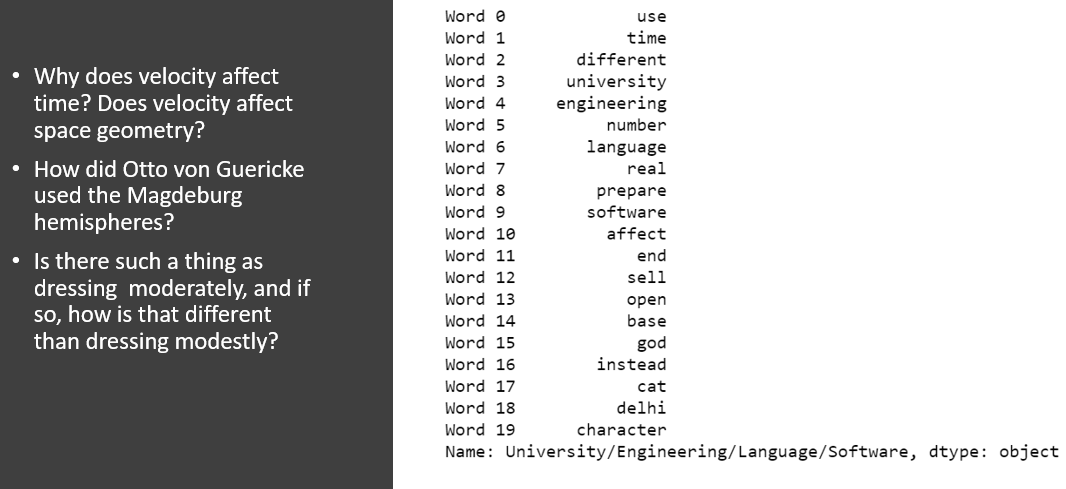


We have these 3 questions on the left, and they were assigned to the topic on the right, as well as each keyword in that topic.


I completely agree with the assignment for the 1st and 2nd question, not sure about the 3rd question, maybe because of the words “dressing modestly” vs. “character”?



# Make Predictions
More accurately, probably we should say how a new question will be allocated to one of these 20 topics.

I went to Quora.com and fetched a couple of popular questions to test our model. Again, the following code were borrowed from this tutorial.

The 1st test question was **“What are the most important lessons you have learned in your life and when did you learn them?”**

In [22]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# Lemmatization, remove pronouns.
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Define function to predict topic for a given new question.
def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores



In [23]:
# Predict the topic
mytext = ["What are the most important lessons you have learned in your life and when did you learn them?"]
topic, prob_scores = predict_topic(text = mytext)
print(topic, prob_scores)

['good', 'job', 'learn', 'change', 'mean', 'money', 'possible', 'college', 'different', 'car', 'government', 'website', 'course', 'easy', 'build', 'offer', 'test', 'available', 'site', 'line'] [[0.00833333 0.00833333 0.00833333 0.175      0.00833333 0.00833333
  0.00833333 0.00833333 0.34166667 0.175      0.00833333 0.00833333
  0.00833333 0.00833333 0.00833333 0.00833333 0.175      0.00833333
  0.00833333 0.00833333]]


Our LDA model was able to find the topic mix in this new question, and word mix in each topic. This new questions has been allocated to the topic has the top keywords like “job, learn, study” and so on, and this topic’s theme is “Job/Learn/Skill improvement”. I agree.


The 2nd test question was “Just like Larry Page and Sergey Brin unseated their incumbents with a better search engine, how likely is it that two Computer Science PhD students create a search engine that unseats Google? How vulnerable is Google to this possibility?”

In [24]:
# Predict the topic
mytext2 = ["Just like Larry Page and Sergey Brin unseated their incumbents with a better search engine, how likely is it that two Computer Science PhD students create a search engine that unseats Google? How vulnerable is Google to this possibility?"]
topic, prob_scores = predict_topic(text = mytext2)
print(topic, prob_scores)

['world', 'ask', 'question', 'human', 'video', 'social', 'song', 'account', 'choose', 'age', 'base', 'datum', 'kill', 'period', 'current', 'open', 'city', 'animal', 'explain', 'model'] [[0.00333333 0.00333333 0.00333333 0.07       0.07       0.13666667
  0.07       0.13666667 0.00333333 0.00333333 0.00333333 0.07
  0.00333333 0.00333333 0.20333333 0.00333333 0.00333333 0.07
  0.00333333 0.13666667]]


Using the same way, this new question has been allocated to the topic that has “country, student, computer, science” and so on as top keywords. The word “computer” and “project” have the highest weight, for this new question. And the theme of the topic is “Student/Internet/Computer/Science/Research”. I agree too.

**NOTES:** This codes are belong to Susan Li, I just wanted to learn and practice from her kernels. You can find her original content below links.

# References
* https://medium.com/towards-data-science/topic-modeling-quora-questions-with-lda-nmf-aff8dce5e1dd
* https://github.com/susanli2016/NLP-with-Python/blob/master/Quora%20Topic%20Modeling_scikit%20learn_LDA.ipynb
* https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/